In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [74]:
data = pd.read_csv("../Data/dataset_churn.csv")

print(data.describe())

        Unnamed: 0          Age       Tenure  MonthlyCharges  TotalCharges
count  3749.000000  3562.000000  3749.000000     3749.000000   3749.000000
mean   1874.000000    43.655531    36.264070       75.844318   2718.968266
std    1082.387408    14.914474    20.505528       73.062971   3211.879149
min       0.000000    18.000000     1.000000       20.000000     13.190000
25%     937.000000    31.000000    19.000000       44.570000   1076.240000
50%    1874.000000    44.000000    36.000000       69.590000   2132.260000
75%    2811.000000    56.000000    54.000000       95.540000   3619.710000
max    3748.000000    69.000000    71.000000     1179.300000  79951.800000


In [75]:
data.isnull().sum()

Unnamed: 0            0
CustomerID            0
Age                 187
Gender                0
Tenure                0
Service_Internet    721
Service_Phone         0
Service_TV            0
Contract              0
PaymentMethod       187
MonthlyCharges        0
TotalCharges          0
StreamingMovies       0
StreamingMusic        0
OnlineSecurity        0
TechSupport           0
Churn                 0
dtype: int64

In [76]:
# Impute missing values for numerical columns with mean
data['Age'].fillna(data['Age'].median(), inplace=True)

# Impute missing values for categorical columns with mode
print(data['PaymentMethod'].mode()[0])
print(data['Service_Internet'].mode()[0])
data['PaymentMethod'].fillna(data['PaymentMethod'].mode()[0], inplace=True)
data['Service_Internet'].fillna(data['Service_Internet'].mode()[0], inplace=True)

# Verify if there are any remaining missing values
data.isnull().sum()


Electronic check
Fiber optic


/var/folders/gr/sd_rtfr170b__hlhhr8n3n240000gn/T/ipykernel_3855/1076413909.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
/var/folders/gr/sd_rtfr170b__hlhhr8n3n240000gn/T/ipykernel_3855/1076413909.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Unnamed: 0          0
CustomerID          0
Age                 0
Gender              0
Tenure              0
Service_Internet    0
Service_Phone       0
Service_TV          0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
StreamingMovies     0
StreamingMusic      0
OnlineSecurity      0
TechSupport         0
Churn               0
dtype: int64

In [77]:
# making a list of interested features excludnig lable 
numerical_features = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']

def iqr_outliers(dataset,feature_name, multiplier=4):
    
    Q1 = dataset[feature_name].quantile(0.25)
    Q3 = dataset[feature_name].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lwr_bound = Q1 - multiplier * IQR
    upp_bound = Q3 + multiplier * IQR 
    
    ls = dataset.index[np.logical_or(dataset[feature_name]<lwr_bound, 
                                dataset[feature_name]>upp_bound)] 
    return ls #return the indexes

outliers_detected={}

for i in numerical_features:
    outliers = iqr_outliers(data,i)
    outliers_detected[i] = outliers
    
    print('Variable',i)
    print(outliers)
    print(data[i].iloc[outliers])
    print('\n')

Variable Age
Index([], dtype='int64')
Series([], Name: Age, dtype: float64)


Variable Tenure
Index([], dtype='int64')
Series([], Name: Tenure, dtype: int64)


Variable MonthlyCharges
Index([  34,  106,  253,  379,  590,  639,  667,  733,  787,  791,  938,  944,
       1043, 1151, 1258, 1261, 1343, 1619, 1904, 1952, 2356, 2495, 2497, 2509,
       2590, 2601, 2736, 2851, 2977, 3137, 3210, 3246, 3514],
      dtype='int64')
34       492.8
106      773.8
253      862.2
379      929.8
590      933.3
639      491.0
667      329.8
733      597.3
787      544.1
791      959.9
938     1119.1
944      995.1
1043     875.0
1151     567.1
1258    1146.0
1261     967.4
1343     436.7
1619    1179.3
1904     607.3
1952     855.1
2356     431.1
2495    1146.6
2497     755.7
2509     663.2
2590     548.8
2601     937.5
2736     597.2
2851     746.8
2977     518.8
3137     632.2
3210     533.5
3246     856.3
3514     619.9
Name: MonthlyCharges, dtype: float64


Variable TotalCharges
Index([  44,  311, 

In [78]:
for i in numerical_features:
    data[i] = data[i].replace(data[i].iloc[outliers_detected[i]].values,data[i].median())

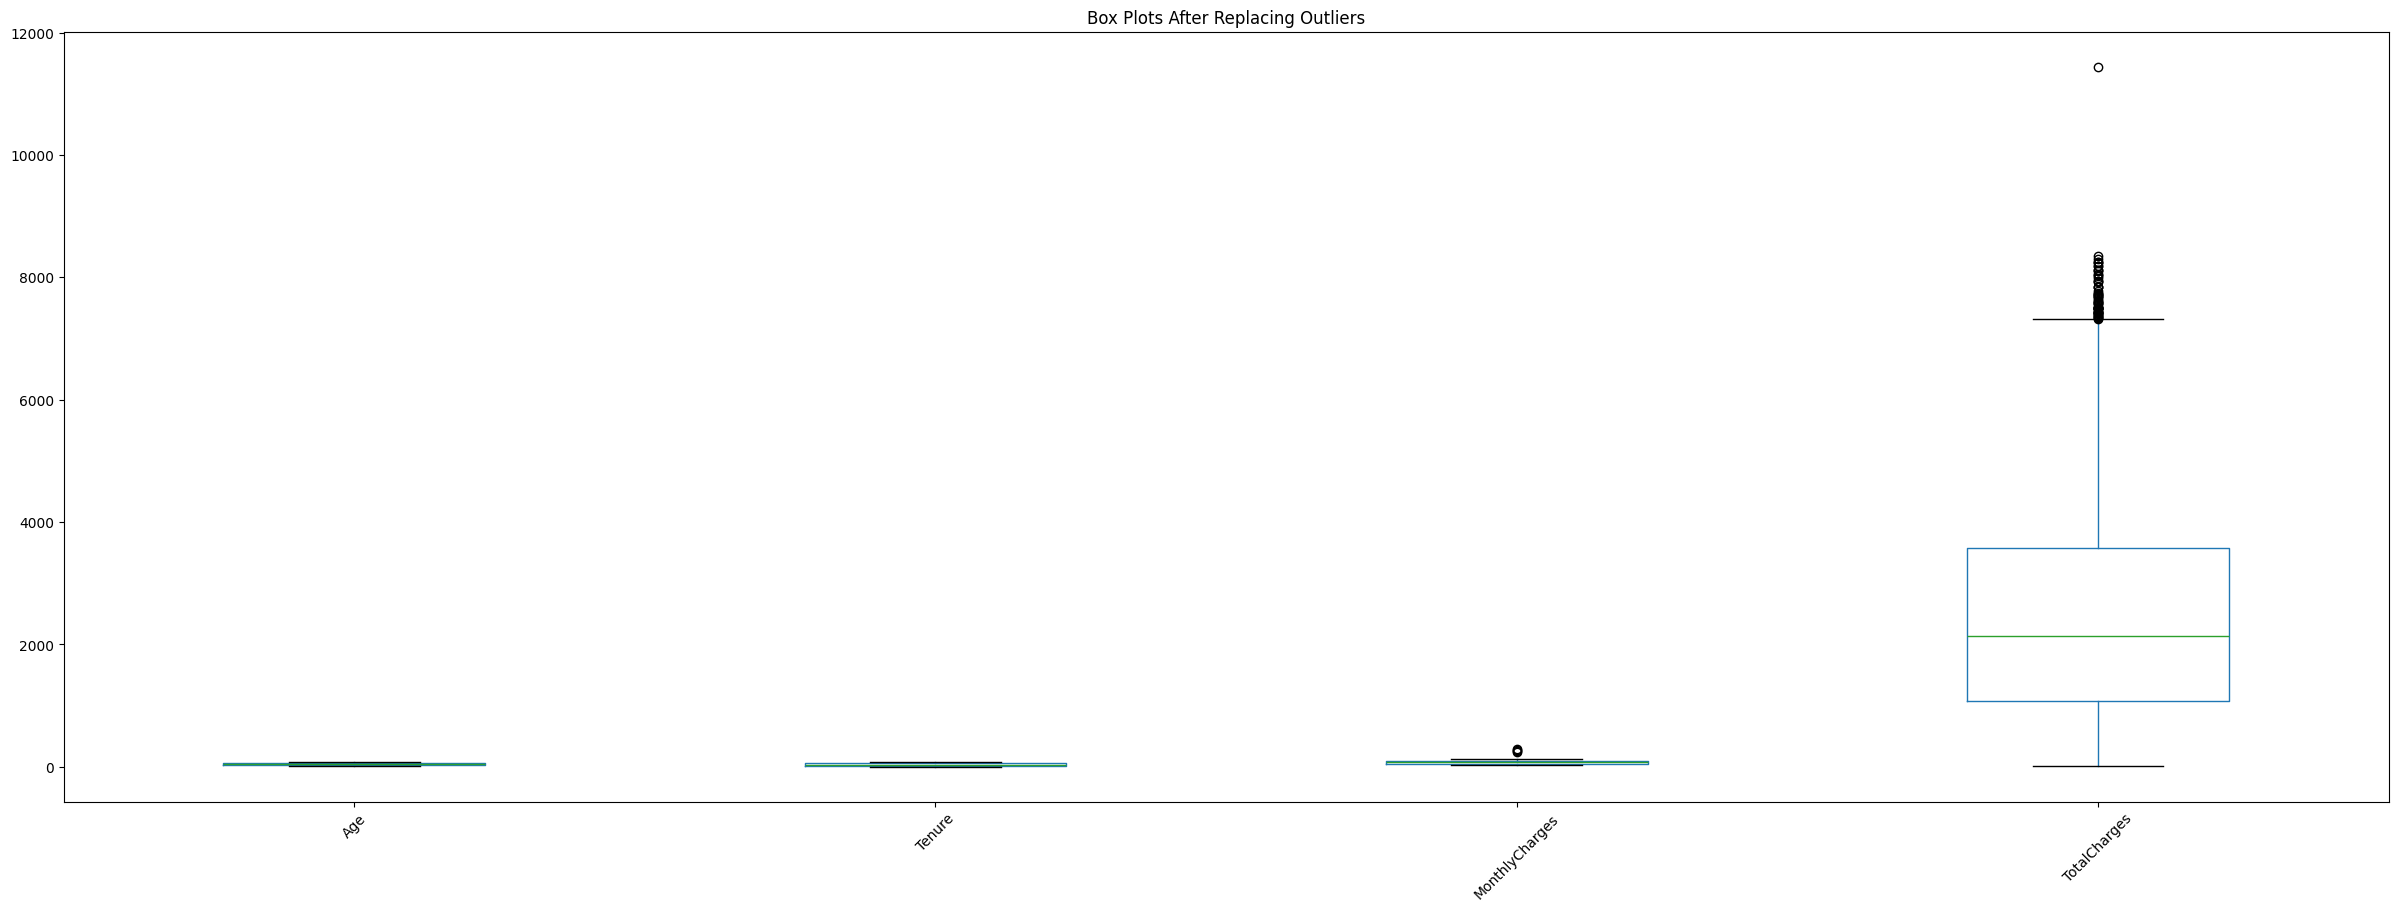

In [79]:
plt.figure(figsize=(30,10))
plt.title(f'Box Plots After Replacing Outliers')
data[numerical_features].boxplot(grid=False)
plt.xticks(rotation=45)
plt.show()

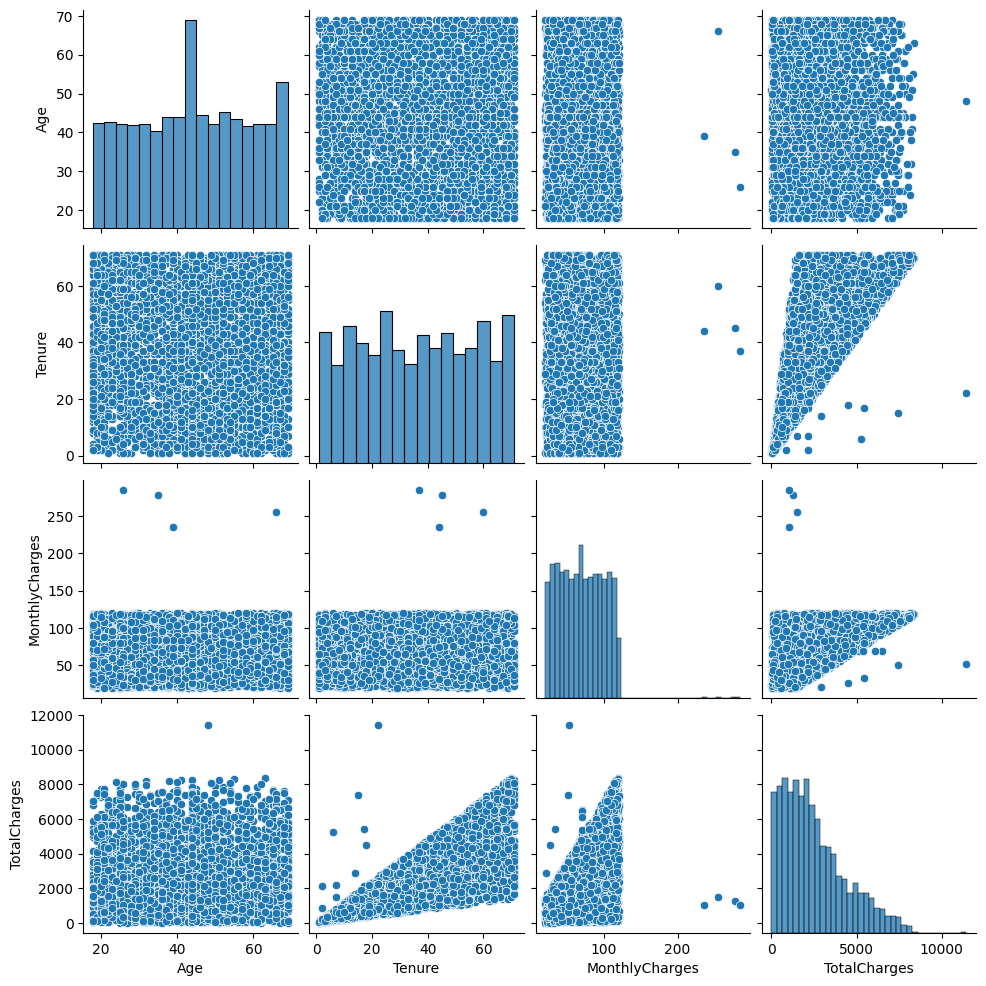

In [80]:
sns.pairplot(data[numerical_features])
plt.show()

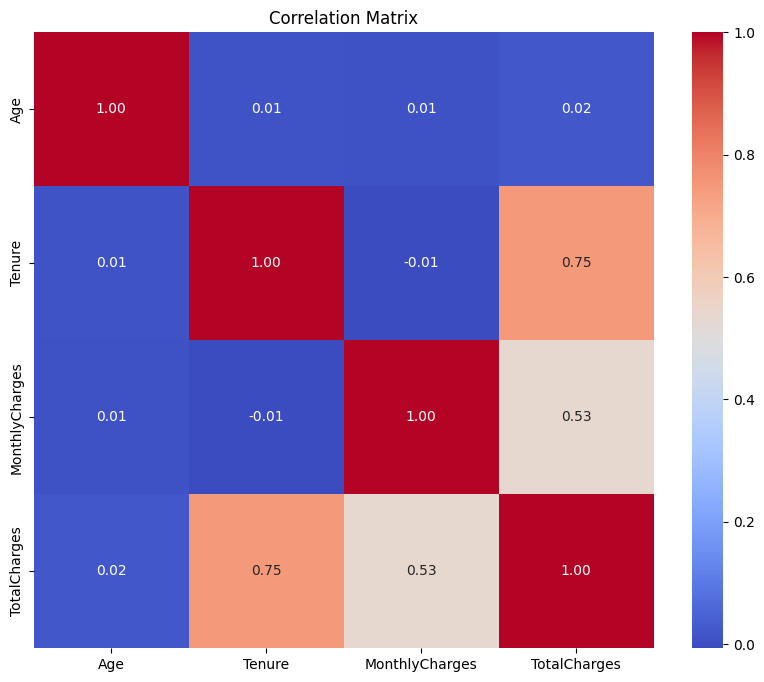

In [81]:
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [82]:
from sklearn.preprocessing import LabelEncoder

# One-hot encoding for nominal categorical features
cat_features = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV', 'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic', 'OnlineSecurity', 'TechSupport']

# Label encoding for binary categorical feature
label_encoder = LabelEncoder()
for feature in cat_features:
    data[feature] = label_encoder.fit_transform(data[feature])

data = data.drop(['Unnamed: 0', 'CustomerID'], axis=1)
# Display the first few rows of the encoded dataset
data.head()



,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn
0,56.0,1,13,0,1,0,1,3,71.88,931.49,0,0,1,0,No
1,69.0,1,13,0,0,1,2,3,110.99,1448.46,1,1,0,0,No
2,46.0,1,60,1,0,1,0,3,116.74,6997.73,1,1,0,0,No
3,32.0,0,57,1,1,1,0,0,78.16,4452.13,0,1,0,1,No
4,60.0,1,52,1,1,1,2,2,30.33,1569.73,1,0,1,1,No


In [83]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X.shape, y.shape

((3749, 14), (3749,))

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [85]:
y_pred = model.predict(X_test)

y_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1060
         Yes       1.00      1.00      1.00        65

    accuracy                           1.00      1125
   macro avg       1.00      1.00      1.00      1125
weighted avg       1.00      1.00      1.00      1125



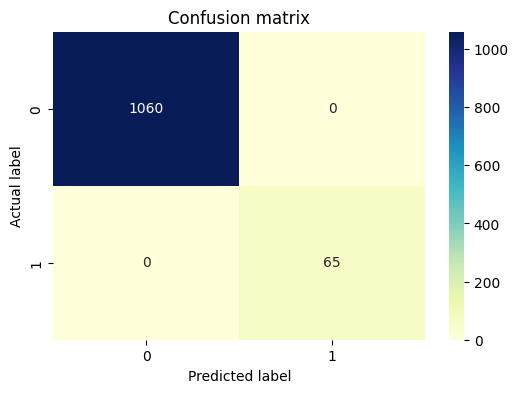

In [87]:
conf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(conf), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()